In [1]:
#import pkgs
import pandas as pd
import numpy as np
import requests
import string
import nltk
import matplotlib.pyplot as plt
from io import BytesIO
from statistics import mean
from sklearn.model_selection import KFold
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn import metrics
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Ciaran
[nltk_data]     Mc\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
#load data from github
url = 'https://raw.githubusercontent.com/cmcswiggan/CIND820/main/SMS_Spam_Dataset'
data = requests.get(url).content
smsData = pd.read_csv(BytesIO(data), sep = '\t', header = None, names = ['Category', 'SMS Message'])

#check data loaded as expected
smsData.head()

,Category,SMS Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
#pre_Process function defined - list required for lemmatization step, will include additional steps in other cases
def pre_Process(sms):
    
    process = list(sms.split(" "))
    return process

#add processed column
smsData['Processed'] = smsData['SMS Message'].apply(lambda x: pre_Process(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point,, crazy.., Available..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar..., Joking, wif, u, oni...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, so, early, hor..., U, c, already..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, don't, think, he, goes, to, usf,, he,..."


In [4]:
#define function for lemmatizing words

def lemm (sms):
    
    lem = [lemmatizer.lemmatize(word) for word in sms]
    return lem

#replace processed column with lemmatized column
smsData['Processed'] = smsData['Processed'].apply(lambda x: lemm(x))

#check dataframe data as anticipated
smsData.head()

,Category,SMS Message,Processed
0,ham,"Go until jurong point, crazy.. Available only ...","[Go, until, jurong, point,, crazy.., Available..."
1,ham,Ok lar... Joking wif u oni...,"[Ok, lar..., Joking, wif, u, oni...]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,"[Free, entry, in, 2, a, wkly, comp, to, win, F..."
3,ham,U dun say so early hor... U c already then say...,"[U, dun, say, so, early, hor..., U, c, already..."
4,ham,"Nah I don't think he goes to usf, he lives aro...","[Nah, I, don't, think, he, go, to, usf,, he, l..."


In [5]:
#add cell with processed data as a string after processing
smsData['Processedstr'] = [' '.join(map(str, l)) for l in smsData['Processed']]

#assign 0 for ham and 1 for spam
for i in range(len(smsData['Category'])):
    if smsData.iloc[i, 0] == 'ham':
        smsData.iloc[i, 0] = 1
    else:
        smsData.iloc[i, 0] = 0

#remove unwanted columns
smsData = smsData[['Category', 'Processedstr']]

#check updated data frame
smsData.head()

,Category,Processedstr
0,1,"Go until jurong point, crazy.. Available only ..."
1,1,Ok lar... Joking wif u oni...
2,0,Free entry in 2 a wkly comp to win FA Cup fina...
3,1,U dun say so early hor... U c already then say...
4,1,"Nah I don't think he go to usf, he life around..."


In [6]:
#split data into 10 folds to run model on each fold
kf = KFold(n_splits = 10, shuffle = True, random_state = 5)

#counter
i = 0

#initiate empty lists and data frame
fold = []
acc = []
prec = []
rec = []
f1 = []
fprt = []
met = []
res = pd.DataFrame()

#split data/loop over each fold and run model 
for train_index, test_index in kf.split(smsData.Processedstr, smsData.Category):
    sms_train, sms_test, label_train, label_test = smsData.Processedstr[train_index], smsData.Processedstr[test_index], smsData.Category[train_index], smsData.Category[test_index]
    
    #labels as integers
    label_train = label_train.astype('int')
    label_test = label_test.astype('int')
    
    #fit and transform training and test data
    vectorizer = TfidfVectorizer(min_df=10)

    train_transformed = vectorizer.fit_transform(sms_train)

    test_transformed = vectorizer.transform(sms_test)
        
    #SVM classifier creation
    clf = SVC()
    clf.fit(train_transformed, label_train)

    #assign predictor
    train_predict = clf.predict(test_transformed)

    #run confusion matrix
    tn, fp, fn, tp = confusion_matrix(label_test, train_predict, labels = [1, 0]).ravel()
    
    #calculate accuracy, precision, recall, F1 score, False Positive Rate
    a = (tp + tn)/(tp + fp + fn + tn)
    p = tp/(tp + fp)
    r = tp/(tp + fn)
    f = (2 * (p * r))/(p + r)
    fpr = fp / (tn + fp)
    
    i = i + 1
    
    #append results to each empty list
    fold.append(i)
    acc.append(a)
    prec.append(p)
    rec.append(r)
    f1.append(f)
    fprt.append(fpr)
    met.append([tp, fp, tn, fn])

#fill dataframe with results from the model/cross-validation 
res['Fold'] = fold    
res['Accuracy'] = acc
res['Precision'] = prec
res['Recall'] = rec
res['F1'] = f1
res['FPR'] = fprt
res['Metrics'] = met

res

,Fold,Accuracy,Precision,Recall,F1,FPR,Metrics
0,1,0.983871,0.986301,0.900000,0.941176,0.002092,"[72, 1, 477, 8]"
1,2,0.992832,1.000000,0.938462,0.968254,0.000000,"[61, 0, 493, 4]"
2,3,0.980251,1.000000,0.858974,0.924138,0.000000,"[67, 0, 479, 11]"
3,4,0.992819,1.000000,0.946667,0.972603,0.000000,"[71, 0, 482, 4]"
4,5,0.976661,0.986486,0.858824,0.918239,0.002119,"[73, 1, 471, 12]"
5,6,0.989228,1.000000,0.923077,0.960000,0.000000,"[72, 0, 479, 6]"
6,7,0.980251,1.000000,0.840580,0.913386,0.000000,"[58, 0, 488, 11]"
7,8,0.985637,0.985075,0.904110,0.942857,0.002066,"[66, 1, 483, 7]"
8,9,0.976661,1.000000,0.841463,0.913907,0.000000,"[69, 0, 475, 13]"
9,10,0.985637,1.000000,0.870968,0.931034,0.000000,"[54, 0, 495, 8]"


In [7]:
#split list of list in dataframe
split = pd.DataFrame(res['Metrics'].to_list(), columns = ['TP', 'FP', 'TN', 'FN'])

#add split columns to results dataframe
res = pd.concat([res, split], axis = 1)#split data into training/test set 70/30
sms_train, sms_test, label_train, label_test = train_test_split(smsData['Processedstr'], smsData['Category'], test_size = 0.3, random_state=25)

#labels as strings
label_train = label_train.astype('int')
label_test = label_test.astype('int')

#drop combined columns
res.drop(columns = 'Metrics', inplace = True)

#check results dataframe
res

,Fold,Accuracy,Precision,Recall,F1,FPR,TP,FP,TN,FN
0,1,0.983871,0.986301,0.900000,0.941176,0.002092,72,1,477,8
1,2,0.992832,1.000000,0.938462,0.968254,0.000000,61,0,493,4
2,3,0.980251,1.000000,0.858974,0.924138,0.000000,67,0,479,11
3,4,0.992819,1.000000,0.946667,0.972603,0.000000,71,0,482,4
4,5,0.976661,0.986486,0.858824,0.918239,0.002119,73,1,471,12
5,6,0.989228,1.000000,0.923077,0.960000,0.000000,72,0,479,6
6,7,0.980251,1.000000,0.840580,0.913386,0.000000,58,0,488,11
7,8,0.985637,0.985075,0.904110,0.942857,0.002066,66,1,483,7
8,9,0.976661,1.000000,0.841463,0.913907,0.000000,69,0,475,13
9,10,0.985637,1.000000,0.870968,0.931034,0.000000,54,0,495,8


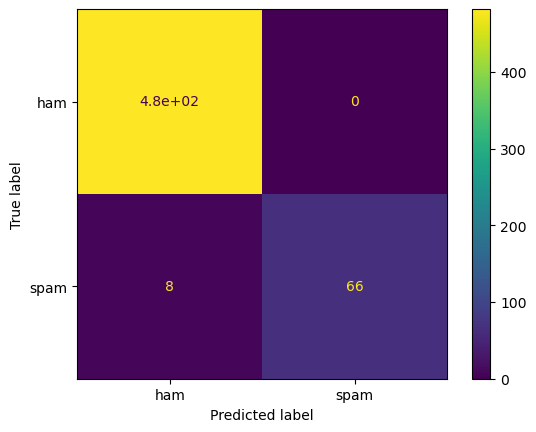

In [8]:
#average results for visualization
TP = round(mean(res['TP']),0)
FP = round(mean(res['FP']),0)
TN = round(mean(res['TN']),0)
FN = round(mean(res['FN']),0)

#create array with confusion matrix results
data = np.array([[TN, FP], [FN, TP]])

#create matrix
cm_display = metrics.ConfusionMatrixDisplay(data, display_labels = ['ham', 'spam'])

#plot
cm_display.plot()
plt.show()

In [9]:
#store list to for use in statistical comparison
f1_svm_case1 = res.loc[:,'F1'].tolist()
fpr_svm_case1 = res.loc[:,'FPR'].tolist()

%store f1_svm_case1
%store fpr_svm_case1

Stored 'f1_svm_case1' (list)
Stored 'fpr_svm_case1' (list)
